# Intro to TensorFlow

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from math import ceil
from numpy.random import seed, shuffle

**My first computation Graph**

In [3]:
# Defining a graph (a default graph)
# Every declared node is automatically added 
# to the 'default-graph'
x = tf.Variable(3, name="x")
y = tf.Variable(5, name="y")
f = x * x * y + y + 2
# Run the graph inside a session.
# With the 'with' command, the session is set as the
# default sesion
with tf.Session() as sess:
    # We need to initialize the variables before
    # performing operations using them
    x.initializer.run() # Equivalent to: tf.get_default_session().run(x.initializer)
    y.initializer.run() # Equivalent to: tf.get_default_session().run(y.initializer)
    result = f.eval()   # Equivalent to: tf.get_default_session().run(f)
    
print(result)

52


In [2]:
# Removing every node inside the
# default graph
tf.reset_default_graph()

# **CONSTRUCTION PHASE**
x = tf.Variable(3, name="x")
y = tf.Variable(5, name="y")
f = x * x * y + y + 2
# Add to the graph a step to initialize all variables
# (we are not actually initializing the variables in this step)
init = tf.global_variables_initializer()

# **EXECUTION PHASE**
with tf.Session() as ses:
    init.run()
    result = f.eval()

print(result)

52


### Evaluating nodes

In [5]:
tf.reset_default_graph()
# Whenever we evaluate a node, Tensorflow automatically
# determines the set of nodes that it depends on.

w  = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3

init = tf.global_variables_initializer()
# **The ineficient way to evaluate a set of nodes**
# By evaluating (y, z) (nodes) the following way, TensorFlow
# has to compute 'w' and 'x' twice in order to obtain (x, z)
with tf.Session() as sess:
    init.run()
    print(y.eval())
    print(z.eval())
    
tf.reset_default_graph()
w  = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3

print()
init = tf.global_variables_initializer()
# **The proper way to evaluate a set of nodes**
with tf.Session() as sess:
    init.run()
    xres, yres = sess.run([y, z])
    print(xres)
    print(yres)

10
15

10
15


Operations in TensorFlow are called *ops*, `tf.constant` and `tf.Variable` are called *source ops* since they take no input. *Ops* with $n$ inputs and $m$ outputs are called *tensors*

## Linear Regression

### Computing $\theta^\star$ with the normal equation

In [6]:
tf.reset_default_graph()
housing = pd.read_csv("./datasets/housing.csv").dropna()
m, n = housing.shape
housing_data_bias = np.c_[np.ones((m, 1)), housing.drop(["ocean_proximity", "median_house_value"], axis=1).values]
housing_target = housing.median_house_value.values.reshape(-1, 1)

# Defining the computation graph 
X = tf.constant(housing_data_bias, dtype=tf.float32, name="X")
y = tf.constant(housing_target, dtype=tf.float32, name="y")
Xtranspose = tf.transpose(X)
theta = tf.matrix_inverse(Xtranspose @ X) @ Xtranspose @ y

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    print(sess.list_devices())
    theta_star = theta.eval() # Equivalent to sess.run(theta)

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[[ -3.60324050e+06]
 [ -4.29331445e+04]
 [ -4.26845234e+04]
 [  1.15434619e+03]
 [ -8.20419979e+00]
 [  1.13781357e+02]
 [ -3.83973656e+01]
 [  4.75008698e+01]
 [  4.02665078e+04]]


### Computing $\theta^\star$ with Gradient Descent
#### Manually Setting the gradients

In [9]:
from sklearn.preprocessing import StandardScaler
tf.reset_default_graph()

housing_data_bias_scaled = StandardScaler().fit_transform(housing_data_bias)

n_epochs = 1000
learning_rate = 0.1
X = tf.constant(housing_data_bias_scaled, dtype=tf.float32, name="X")
y = tf.constant(housing.median_house_value.values.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n - 1, 1], minval=-1, maxval=1), name="theta")

y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="MSE")
# **Taking a step of gradient descent**
# ---------------- Manual Differentiation----------------
gradients = 2 / m * tf.matmul(tf.transpose(X), error)
# Updating the parameters
training_op = tf.assign(theta, theta - learning_rate * gradients)
# ---------------- Manual Differentiation----------------

init = tf.global_variables_initializer()

with tf.Session() as sess:
    # Step 1) Initialize all variables
    sess.run(init)
    # Step 2) Iterate over epochs
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            # Evaluate current mse variable
            print(f"@Epoch {epoch:03}, MSE: {mse.eval():0,.2f}")
        # update the training operation: compute gradients
        sess.run(training_op)
    theta_star = theta.eval()

@Epoch 000, MSE: 56,117,448,704.00
@Epoch 100, MSE: 47,701,590,016.00
@Epoch 200, MSE: 47,639,318,528.00
@Epoch 300, MSE: 47,633,567,744.00
@Epoch 400, MSE: 47,632,191,488.00
@Epoch 500, MSE: 47,631,593,472.00
@Epoch 600, MSE: 47,631,310,848.00
@Epoch 700, MSE: 47,631,142,912.00
@Epoch 800, MSE: 47,631,052,800.00
@Epoch 900, MSE: 47,630,999,552.00


### Computing $\theta^\star$ with Gradient Descent
#### Using automatic differentiation

In [21]:
from sklearn.preprocessing import StandardScaler
tf.reset_default_graph()

housing_data_bias_scaled = StandardScaler().fit_transform(housing_data_bias)

n_epochs = 1000
learning_rate = 0.1
X = tf.constant(housing_data_bias_scaled, dtype=tf.float32, name="X")
y = tf.constant(housing.median_house_value.values.reshape(-1, 1), dtype=tf.float32, name="y")
# Initializing the parameters to learn
theta = tf.Variable(tf.random_uniform([n - 1, 1], minval=-1, maxval=1), name="theta")

y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="MSE")
# **Taking a step of gradient descent**
# ---------------- Automatic Differentiation----------------
gradients = tf.gradients(mse, [theta])[0]
training_op = tf.assign(theta, theta - learning_rate * gradients)
# ---------------- Automatic Differentiation----------------

init = tf.global_variables_initializer()

with tf.Session() as sess:
    # Step 1) Initialize all variables
    sess.run(init)
    # Step 2) Iterate over epochs
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            # Evaluate current mse variable
            print(f"@Epoch {epoch:03}, MSE: {mse.eval():0,.2f}")
        # update the training operation: comppute gradients
        sess.run(training_op)
    theta_star = theta.eval()

@Epoch 000, MSE: 56,117,559,296.00
@Epoch 100, MSE: 47,701,585,920.00
@Epoch 200, MSE: 47,639,318,528.00
@Epoch 300, MSE: 47,633,567,744.00
@Epoch 400, MSE: 47,632,191,488.00
@Epoch 500, MSE: 47,631,593,472.00
@Epoch 600, MSE: 47,631,306,752.00
@Epoch 700, MSE: 47,631,142,912.00
@Epoch 800, MSE: 47,631,052,800.00
@Epoch 900, MSE: 47,630,999,552.00


### Computing $\theta^\star$ with Gradient Descent
#### Using an Optimizer

In [9]:
from sklearn.preprocessing import StandardScaler
tf.reset_default_graph()

housing_data_bias_scaled = StandardScaler().fit_transform(housing_data_bias)

n_epochs = 1000
learning_rate = 0.1
X = tf.constant(housing_data_bias_scaled, dtype=tf.float32, name="X")
y = tf.constant(housing.median_house_value.values.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n - 1, 1], minval=-1, maxval=1), name="theta")

y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="MSE")
# **Taking a step of gradient descent**
# ---------------- TF Optimizer ----------------
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)
# ---------------- TF Optimizer ----------------

init = tf.global_variables_initializer()

with tf.Session() as sess:
    # Step 1) Initialize all variables
    sess.run(init)
    # Step 2) Iterate over epochs
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            # Evaluate current mse variable
            print(f"@Epoch {epoch:03}, MSE: {mse.eval():0,.2f}")
        # update the training operation: comppute gradients
        sess.run(training_op)
    theta_star = theta.eval()

@Epoch 000, MSE: 56,117,612,544.00
@Epoch 100, MSE: 47,701,594,112.00
@Epoch 200, MSE: 47,639,330,816.00
@Epoch 300, MSE: 47,633,571,840.00
@Epoch 400, MSE: 47,632,187,392.00
@Epoch 500, MSE: 47,631,601,664.00
@Epoch 600, MSE: 47,631,306,752.00
@Epoch 700, MSE: 47,631,142,912.00
@Epoch 800, MSE: 47,631,052,800.00
@Epoch 900, MSE: 47,631,003,648.00


----
### Computing $\theta^\star$ with Mini-Batch Gradient Descent
#### The use of Placeholders for model learning

In [39]:
def fetch_batch(n_batches, set_seed=None):
    """
    Retrieve the i-th batch from a random shuffled
    training dataset. Each epoch the training
    dataset gets reshuffled.
    """
    seed(set_seed)
    batches = np.c_[housing_data_bias_scaled, housing_target]
    shuffle(batches)
    batches = np.array_split(batches, n_batches)
    for batch in batches:
        yield batch[:, :-1], batch[:, -1].reshape(-1, 1)

In [33]:
tf.reset_default_graph()
batch_size = 5000
n_epochs = 1000
n_batches = ceil(m / batch_size)

X = tf.placeholder(tf.float32, shape=[None, n - 1], name="X")
y = tf.placeholder(tf.float32, shape=[None, 1], name="y")
theta = tf.Variable(tf.random_uniform([n - 1, 1], minval=-1, maxval=1), name="theta")

y_pred = tf.matmul(X, theta)
err = y_pred - y
mse = tf.reduce_mean(tf.square(err), name="MSE")
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        for X_batch, y_batch in fetch_batch(n_batches, set_seed=epoch):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 100 == 0:
            # Evaluate current mse variable
            print(f"@Epoch {epoch:03}, MSE: {mse.eval(feed_dict={X: X_batch, y: y_batch}):0,.2f}")
    theta_star_bgd = theta.eval()

@Epoch 000, MSE: 49,532,694,528.00
@Epoch 100, MSE: 46,844,346,368.00
@Epoch 200, MSE: 47,022,866,432.00
@Epoch 300, MSE: 47,475,621,888.00
@Epoch 400, MSE: 47,403,696,128.00
@Epoch 500, MSE: 47,448,813,568.00
@Epoch 600, MSE: 46,916,739,072.00
@Epoch 700, MSE: 47,627,169,792.00
@Epoch 800, MSE: 47,496,564,736.00
@Epoch 900, MSE: 47,253,815,296.00


----
### Saving and restoring models
#### *Saving a file*

In [30]:
tf.reset_default_graph()
batch_size = 5000
n_epochs = 1000
n_batches = ceil(m / batch_size)

X = tf.placeholder(tf.float32, shape=[None, n - 1], name="X")
y = tf.placeholder(tf.float32, shape=[None, 1], name="y")
theta = tf.Variable(tf.random_uniform([n - 1, 1], minval=-1, maxval=1), name="theta")

y_pred = tf.matmul(X, theta)
err = y_pred - y
mse = tf.reduce_mean(tf.square(err), name="MSE")
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        for X_batch, y_batch in fetch_batch(n_batches):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 100 == 0:
            # Checkpoint every 100 epochs
            save_path = saver.save(sess, "./tmp/linear_regression.ckpt")
            # Evaluate current mse variable
            print(f"@Epoch {epoch:03}, MSE: {mse.eval(feed_dict={X: X_batch, y: y_batch}):0,.2f}")
    theta_star_bgd = theta.eval()
    save_path = saver.save(sess, "./tmp/my_model_final.ckpt")

@Epoch 000, MSE: 49,532,710,912.00
@Epoch 100, MSE: 46,844,350,464.00
@Epoch 200, MSE: 47,022,866,432.00
@Epoch 300, MSE: 47,475,621,888.00
@Epoch 400, MSE: 47,403,692,032.00
@Epoch 500, MSE: 47,448,813,568.00
@Epoch 600, MSE: 46,916,739,072.00
@Epoch 700, MSE: 47,627,169,792.00
@Epoch 800, MSE: 47,496,564,736.00
@Epoch 900, MSE: 47,253,815,296.00


----
### Saving and restoring models
#### *Restoring a File*

In [34]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=[None, n - 1], name="X")
y = tf.placeholder(tf.float32, shape=[None, 1], name="y")
theta = tf.Variable(tf.random_uniform([n - 1, 1 ], minval=-1, maxval=1), name="theta")

y_pred = tf.matmul(X, theta, name="y_pred")
mse = tf.reduce_mean(tf.square(y_pred - y), name="MSE")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, "./tmp/my_model_final.ckpt")
    for epoch in range(n_epochs):
        for X_batch, y_batch in fetch_batch(n_batches):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 100 == 0:
            # Checkpoint every 100 epochs
            save_path = saver.save(sess, "./tmp/linear_regression.ckpt")
            # Evaluate current mse variable
            print(f"@Epoch {epoch:03}, MSE: {mse.eval(feed_dict={X: X_batch, y: y_batch}):0,.2f}")
    theta_star_bgd = theta.eval()
    save_path = saver.save(sess, "./tmp/my_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./tmp/my_model_final.ckpt
@Epoch 000, MSE: 47,592,103,936.00
@Epoch 100, MSE: 47,399,989,248.00
@Epoch 200, MSE: 47,747,645,440.00
@Epoch 300, MSE: 47,565,201,408.00
@Epoch 400, MSE: 48,000,819,200.00
@Epoch 500, MSE: 47,279,427,584.00
@Epoch 600, MSE: 47,240,843,264.00
@Epoch 700, MSE: 47,740,170,240.00
@Epoch 800, MSE: 47,980,371,968.00
@Epoch 900, MSE: 48,388,489,216.00


### TensorBoard

In [38]:
from datetime import datetime
learning_rate = 0.1
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root = "tf_logs"
logdir = f"{root}/run-{now}"

tf.reset_default_graph()
batch_size = 5000
n_epochs = 1000
n_batches = ceil(m / batch_size)

X = tf.placeholder(tf.float32, shape=[None, n - 1], name="X")
y = tf.placeholder(tf.float32, shape=[None, 1], name="y")
theta = tf.Variable(tf.random_uniform([n - 1, 1], minval=-1, maxval=1), name="theta")

y_pred = tf.matmul(X, theta)
# Name scope: To group relating nodes into a single
# *graphical* node
with tf.name_scope("loss") as scope:
    err = y_pred - y
    mse = tf.reduce_mean(tf.square(err), name="MSE")
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()
saver = tf.train.Saver()
mse_summary = tf.summary.scalar("MSE", mse)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        for X_batch, y_batch in fetch_batch(n_epochs):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            if batch_ix % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y:y_batch})
                step = epoch * n_batches + batch_ix
                file_writer.add_summary(summary_str, step )
        if epoch % 100 == 0:
            # Checkpoint every 100 epochs
            save_path = saver.save(sess, "./tmp/linear_regression.ckpt")
            # Evaluate current mse variable
            print(f"@Epoch {epoch:03}, MSE: {mse.eval(feed_dict={X: X_batch, y: y_batch}):0,.2f}")
    theta_star_bgd = theta.eval()
    save_path = saver.save(sess, "./tmp/my_model_final.ckpt")
file_writer.close()

@Epoch 000, MSE: 23,291,740,160.00
@Epoch 100, MSE: 36,742,144,000.00
@Epoch 200, MSE: 45,800,816,640.00
@Epoch 300, MSE: 43,153,838,080.00
@Epoch 400, MSE: 51,082,092,544.00
@Epoch 500, MSE: 43,747,704,832.00
@Epoch 600, MSE: 33,567,025,152.00
@Epoch 700, MSE: 38,498,402,304.00
@Epoch 800, MSE: 46,691,311,616.00
@Epoch 900, MSE: 1,822,485,905,408.00


### Modularity

In [27]:
tf.reset_default_graph()
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root = "tf_logs"
logdir = f"{root}/run-{now}"

def relu(X):
    with tf.name_scope("relu"):
        w_shape = (int(X.get_shape()[1]), 1)
        w = tf.Variable(tf.random_normal(w_shape), name="weights")
        b = tf.Variable(0., name="bias")
        z = tf.add(tf.matmul(X, w), b, name="z")
        return tf.maximum(z, 0., name="relu")

n_features = 3
X = tf.placeholder(tf.float32, shape=[None, n_features], name="X")
relus = [relu(X) for _ in range(5)]
output = tf.add_n(relus, name="output")

init = tf.global_variables_initializer()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
file_writer.close()

### Sharing Weights

In [37]:
tf.reset_default_graph()
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root = "tf_logs"
logdir = f"{root}/run-{now}"

def relu(X):
    with tf.variable_scope("relu", reuse=True):
        threshold = tf.get_variable("threshold")
        w_shape = (int(X.get_shape()[1]), 1)
        w = tf.Variable(tf.random_normal(w_shape), name="weights")
        b = tf.Variable(0., name="bias")
        z = tf.add(tf.matmul(X, w), b, name="z")
        return tf.maximum(z, 0., name="relu")

n_features = 3
X = tf.placeholder(tf.float32, shape=[None, n_features], name="X")
with tf.variable_scope("relu"):
    threshold = tf.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))
relus = [relu(X) for _ in range(5)]
output = tf.add_n(relus, name="output")

init = tf.global_variables_initializer()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
file_writer.close()

# Exercises

**1. What are the main benefits of creating a computation graph rather than directly executing the computations? What are the main drawbacks?**  
Creating a computation graph allows us to run operations in parallel across CPUs and GPUs; its main drawback is the lack of instantaneously evaluating any node to see its output, we need to execute the graph in order to do so.

**2. Is the statment `a_val = a.eval(session=sess)` equivalent to `a_val = sess.run(a)`?**  
Yes, since both operations run under the same session and execute the computation graph in the exact same way.

**3. Is the statement `a_val, b_val = a.eval(session.sess), b.eval(session.sess)` equivalent to `a_val, b_val = sess.run([a, b])`?**  
No, the first statement runs the graph two times: values affecting both `a` and `b` must be computed twice in order to reach an output; the second statement, on the other hand, evaluates both `a` and `b` in paralell.

**4. Can you run two graphs in the same session?**


In [120]:
graph1 = tf.Graph()
with graph1.as_default():
    x1 = tf.Variable(3, name="x1")
    y1 = tf.Variable(1, name="x2")
    z1 = x1 * x1 + y1
    init1 = tf.global_variables_initializer()

graph2 = tf.Graph()
with graph2.as_default():
    x2 = tf.Variable(3, name="x2")
    y2 = tf.Variable(1, name="y2")
    z2 = x2 * x2 + y2
    init2 = tf.global_variables_initializer()

with tf.Session(graph=graph1) as sess:
    sess.run(init1)
    print(f"Running graph1 {z1.eval()}")
    
with tf.Session(graph=graph2) as sess:
    sess.run(init2)
    print(f"Running graph2 {z2.eval()}")

Running graph1 10
Running graph2 10


Attempting to run two graphs in a session will results in an error since `tf.Session` takes a single graph as a parameter. Therefore, it is **not** possible to run two graphs in a same session.

**5. If you create a graph `g` containing a variable `w`, then start two threads and open a session in each thread, both using the same graph `g`, will each session have its own copy of the variable `w` or will it be shared?**  
Each session will have its own copy of `w`, since all `g` does is to define what will happen once (any) session runs that graph.

**6. When is a variable initialized? When is it destroyed?**  
A variable is initialized when its initializer is run, and it is destroyed when the session is closed.

**7. What is the difference between a placeholder and a variable?**
A placeholder, as the name suggests, is a TensorFlow object that will recieve some input during the execution phase. On the other hand, a variable is a TensorFlow object which we will modify as the session runs.

Another way to think about it is that a placeholder will store $X$, for which we only know its shape but not how many training instances and the instances themselves, and a variable will store $\theta$

**8. What happens when you run the graph to evaluate an operation that depends on a placeholder but you don't feed its value? What happens if the operations does not depend on the placeholder?**  
TensorFlow raisses an error if an operation that depends on a placeholder is not fed; if the operation does not depend on the placeholder, there is no data to feed, therefore, no error gets raised

In [130]:
tf.reset_default_graph()
x = tf.placeholder(shape=None, dtype=tf.float32)
fx = tf.pow(x, 2)

train_val = 3
with tf.Session() as sess:
    # *** Raises and error if feed_dict is not provided ***
    fx_val = sess.run(fx, feed_dict={x: train_val})
    print(fx_val)

9.0


**9. When you run a graph, can you feed the output value of any operation, or just the value of placeholders?**  
It is possible to feed the output value of any operation.

In [170]:
tf.reset_default_graph()

c = tf.placeholder(tf.float32)
x = tf.Variable(2, dtype=tf.float32)
op = tf.multiply(c, x, name="operation")

with tf.Session() as sess:
    sess.run(x.initializer)
    print("Running op = x * c. Feeding c:3")
    print(sess.run(op, feed_dict={c:3}), end="\n\n")
    print("Running op = x * c. Feeding c:3 & x:10")
    print(sess.run(op, feed_dict={x: 10, c:30}))

Running op = x * c. Feeding c:3
6.0

Running op = x * c. Feeding c:3 & x:10
300.0


**10. How can you set a variable to any value you want (during the execution phase)?**  
Assuming `X` is the variable we want to set a value to, we can set this value (inside a session) as
```
    sess.run(X, feed_dict{X: val})
```

**11. How many times does the reverse-mode autodiff need to traverse the graph in order to compute the gradients of the cost function with regard to 10 variables? What about forward-mode autodiff? And symbolic differentiation?**
* reverse-mode: 1 time.
* symbolic-diff: 10
* forward-mode: depends on the number of inputs

**12. implement Logistic Regression with Mini-bacth Gradient Descent using TensorFlow. Train it and evaluate it on the moons datasets.**

   * Define the graph within a `logisitc_regression()` function that can be reused easily
   * Save checkpoints using a `Saver` at regular intervals during training, and save the model at the end of training.
   * Restore the last checkpoint upon startup if training was interrumpted.
   * Define the graph using nice scopes to that the graph looks good in TensorBoard
   * Add summaries to visualize the learnning curve in TensorBoard
   * Try tweaking some hyperparameters such as the learning rate or the mini-batch size and look at the shape of the learning curve.

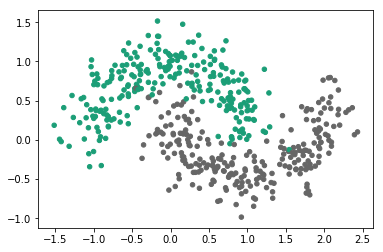

In [23]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from datetime import datetime
import os
X_moons, y_moons = make_moons(n_samples=500, noise=0.2, random_state=314)
y_moons = y_moons.reshape(-1, 1)
plt.scatter(*X_moons.T, c=y_moons.ravel(), s=20, cmap="Dark2");

In [4]:
def fetch_batches(X, y, n_batches, set_seed=None):
    """
    Retrieve the i-th batch from a random shuffled
    training dataset. Each epoch the training
    dataset gets reshuffled.
    """
    seed(set_seed)
    batches = np.c_[X, y]
    shuffle(batches)
    batches = np.array_split(batches, n_batches)
    for batch in batches:
        yield batch[:, :-1], batch[:, -1].reshape(-1, 1)

In [36]:
tf.reset_default_graph()
now = datetime.now().strftime("%m%d%y%H%M%S")
logfile = f"./tf_logs/run-{now}"
learning_rate = 0.01
epochs = 100
n_batches = 10

# Values to predict the decision grid
x1min, x2min = X_moons.min(axis=0)
x1max, x2max = X_moons.max(axis=0)
x1grid, x2grid = np.mgrid[x1min:x1max:0.01, x2min:x2max:0.01]
np.c_[x1grid.reshape(-1, 1), x2grid.reshape(-1, 1)]

with tf.name_scope("inputs") as inputs:
    X = tf.placeholder(tf.float32, shape=(None, 2), name="X")
    y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

with tf.name_scope("Y_pred") as y_pred:
    m = X.get_shape().as_list()[1]
    theta = tf.Variable(tf.zeros((m, 1)), name="theta")
    bias = tf.Variable(tf.zeros(1))
    y_hat = tf.sigmoid(tf.matmul(X, theta) + bias , name="y_hat")

with tf.name_scope("loss") as loss:
    err = -tf.reduce_sum(y * tf.log(y_hat) + (1 - y) * tf.log(1 - y_hat))

with tf.name_scope("metrics") as met:
    y_pred = tf.round(y_hat, name="predictions")
    correct_preds = tf.equal(y_pred, y)
    accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))

with tf.name_scope("optimizer") as opt:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_step = optimizer.minimize(err)

with tf.name_scope("components") as comp:
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    summary_loss = tf.summary.scalar("Cross_Entropy", err)
    file_writer = tf.summary.FileWriter(logfile, tf.get_default_graph())

with tf.Session() as sess:
    # If a model has already been trained, there is no need
    # to run sess.run(init); since the variables will be
    # loaded from saver.restore
    saver.restore(sess, "./tmp/my_model_final.ckpt")
    #sess.run(init)
    for epoch in range(epochs):
        for nbatch, (X_batch, y_batch) in enumerate(fetch_batches(X_moons, y_moons, n_batches)):
            sess.run(training_step, feed_dict={X:X_moons, y:y_moons})
            if nbatch % 2 == 0:
                summary = summary_loss.eval(feed_dict={X: X_moons, y:y_moons})
                file_writer.add_summary(summary, epoch)
        if epoch % 20 == 0:
            acc, ce = sess.run([accuracy, err], feed_dict={X:X_moons, y:y_moons})
            save_path = saver.save(sess, "./tmp/my_model.ckpt")
            print(f"Accuracy at {epoch + 1:02}: {acc:0.3%} // CError {ce:0.3f}")
    final_pred = y_pred.eval(feed_dict={X:np.c_[x1grid.reshape(-1, 1), x2grid.reshape(-1, 1)]})
    save_path = saver.save(sess, "./tmp/my_model_final.ckpt")
file_writer.close()

INFO:tensorflow:Restoring parameters from ./tmp/my_model_final.ckpt
Accuracy at 01: 87.600% // CError 137.321
Accuracy at 21: 87.600% // CError 137.321
Accuracy at 41: 87.600% // CError 137.321
Accuracy at 61: 87.600% // CError 137.321
Accuracy at 81: 87.600% // CError 137.321


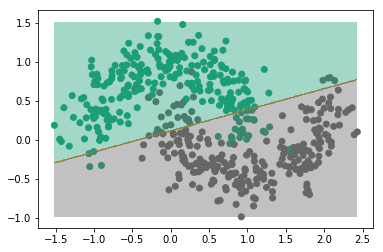

In [37]:
final_pred = final_pred.reshape(x1grid.shape)
plt.scatter(*X_moons.T, c=y_moons.ravel(), cmap="Dark2")
plt.contourf(x1grid, x2grid, final_pred, cmap="Dark2", alpha=0.4) 

### Computation graph for the Logistic Regression
<img width=500 src="./images/logreg_graph.png"/>